Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Steps followed:

1. Understand the data
2. Data visualization
3. Model building
    - Create model with input data as-is
    - Create model after data augmentation
    - Create model after handling class imbalances
4. Summary

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')
from glob import glob

2023-12-06 20:04:33.703131: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Importing Skin Cancer Data

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('./Dataset/Train')
data_dir_test = pathlib.Path('./Dataset/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split = 0.2,
    subset = 'training',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


2023-12-06 20:04:59.057434: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    validation_split = 0.2,
    subset = 'validation',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

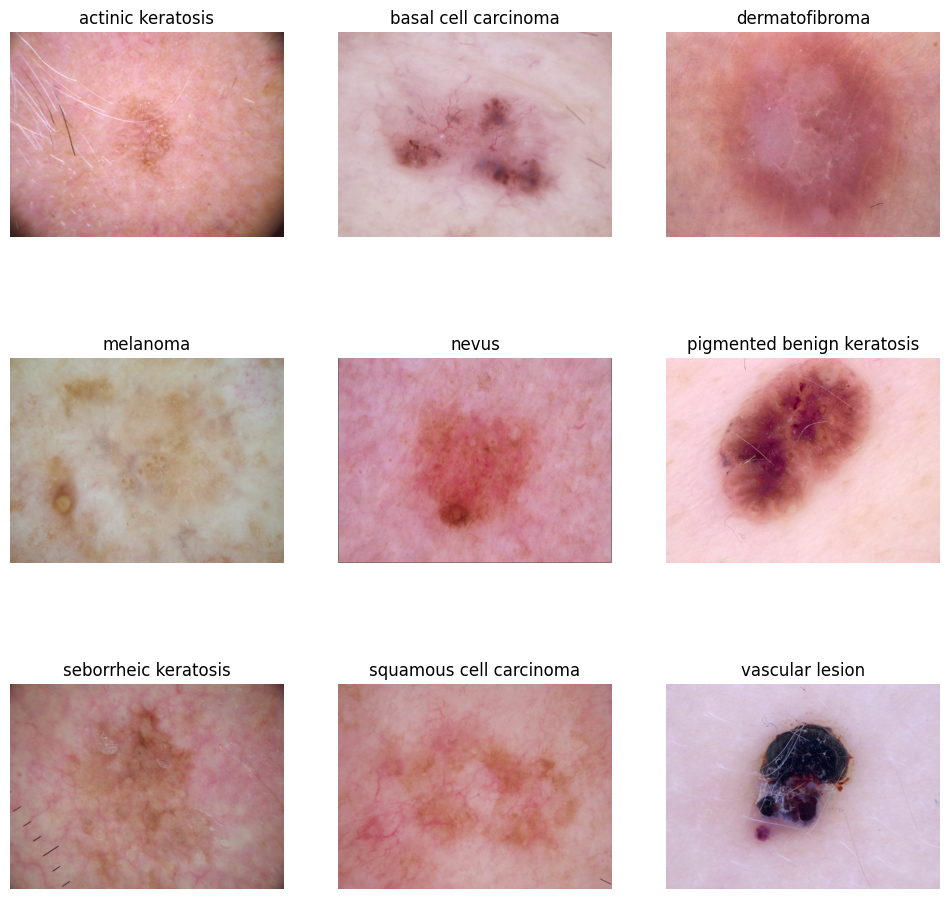

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
index = 0
plt.figure(figsize=(12,12))

for name in class_names:
    images = list(glob(os.path.join(data_dir_train, name, '*')))
    img = PIL.Image.open(str(images[0]))
    index += 1
    ax = plt.subplot(3,3, index)
    plt.imshow(img)
    plt.title(name)
    plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

#### Model 1 - Create model with optimizer and loss function

In [11]:
num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy']
             )

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        1

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/20
56/56 [==============================] - 24s 323ms/step - loss: 1.9969 - accuracy: 0.2494 - val_loss: 2.5303 - val_accuracy: 0.0870
Epoch 2/20
56/56 [==============================] - 17s 300ms/step - loss: 1.8715 - accuracy: 0.3058 - val_loss: 2.7649 - val_accuracy: 0.2609
Epoch 3/20
56/56 [==============================] - 17s 309ms/step - loss: 1.8086 - accuracy: 0.3309 - val_loss: 2.8273 - val_accuracy: 0.2174
Epoch 4/20
56/56 [==============================] - 20s 364ms/step - loss: 1.6380 - accuracy: 0.4185 - val_loss: 2.3927 - val_accuracy: 0.2609
Epoch 5/20
56/56 [==============================] - 26s 457ms/step - loss: 1.5846 - accuracy: 0.4392 - val_loss: 2.2454 - val_accuracy: 0.2609
Epoch 6/20
56/56 [==============================] - 21s 373ms/step - loss: 1.4617 - accuracy: 0.4794 - val_loss: 2.4123 - val_accuracy: 0.2609
Epoch 7/20
56/56 [==============================] - 19s 341ms/step - loss: 1.4457 - accuracy: 0.4810 - val_loss: 2.3254 - val_accuracy: 0.3043

### Visualizing training results

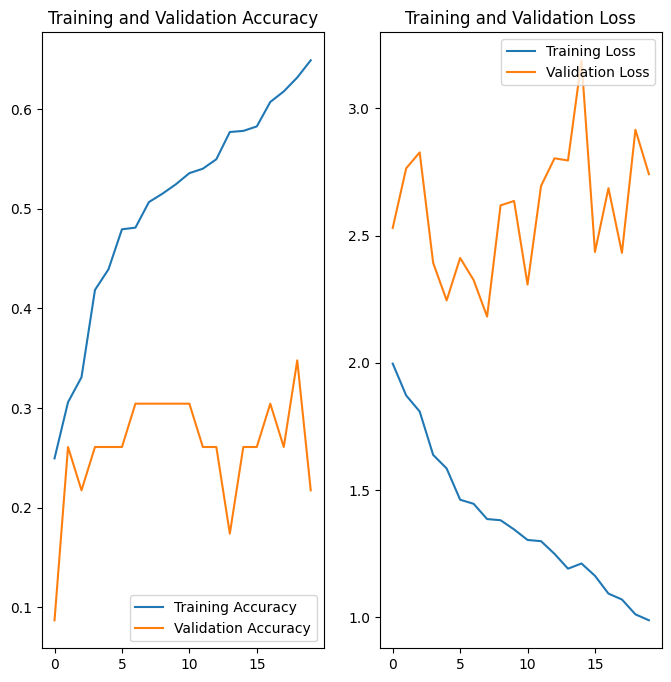

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Observation:
- Training data accuracy: 64%
- Validation data accuracy: 21%

- This model overfits the training data (training and validation accuracy is greater than +/- 5%)
- Also, training and validation data loss is inversely proportional to each other

### Data Augmentation

In [16]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

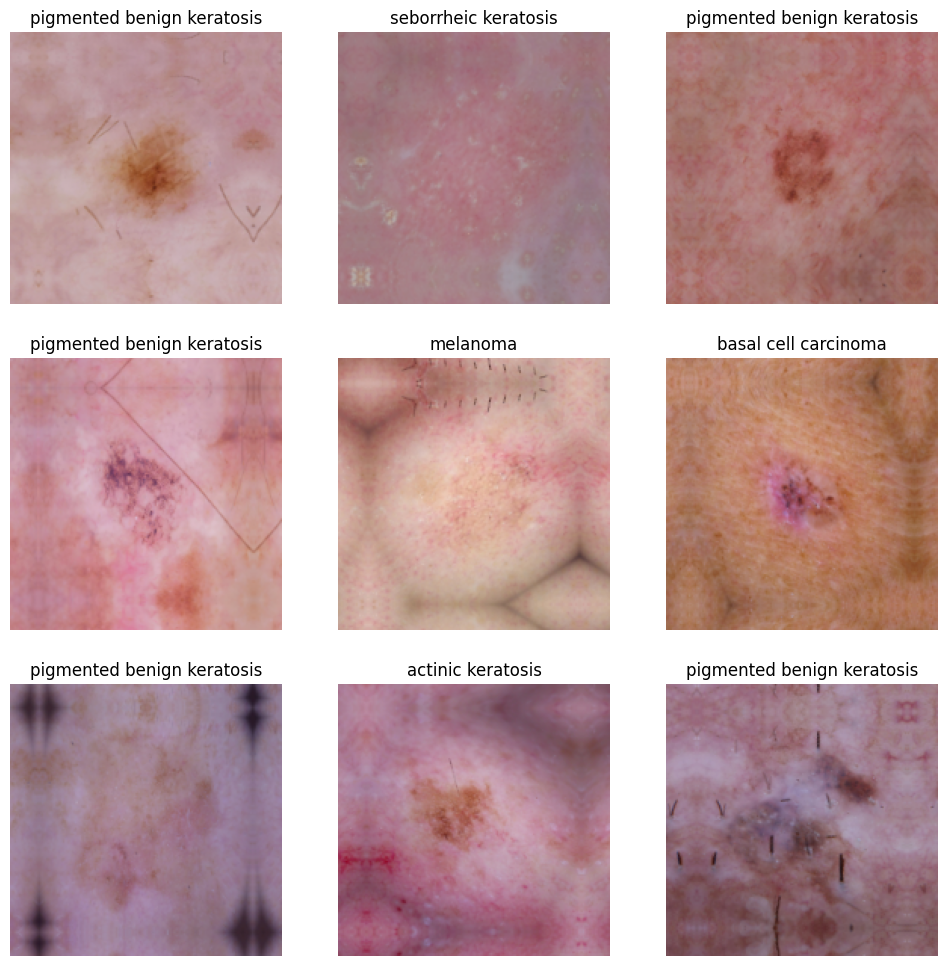

In [17]:
plt.figure(figsize=(12,12))

for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_image = data_augument(images)[i]
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image.numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [18]:
### Model 2: Create model with augumented image

In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

dropout_conv = 0.05
dropout_dense = 0.25

model_aug = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    data_augument,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),  
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(dropout_dense),
    tf.keras.layers.Dense(num_classes)
])



### Compiling the model

In [20]:
model_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20

history = model_aug.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/20
56/56 [==============================] - 28s 431ms/step - loss: 1.9799 - accuracy: 0.2522 - val_loss: 2.6835 - val_accuracy: 0.1739
Epoch 2/20
56/56 [==============================] - 24s 435ms/step - loss: 1.7339 - accuracy: 0.3689 - val_loss: 2.6907 - val_accuracy: 0.2609
Epoch 3/20
56/56 [==============================] - 27s 484ms/step - loss: 1.6192 - accuracy: 0.4258 - val_loss: 2.7959 - val_accuracy: 0.3043
Epoch 4/20
56/56 [==============================] - 26s 455ms/step - loss: 1.5759 - accuracy: 0.4498 - val_loss: 2.2440 - val_accuracy: 0.2609
Epoch 5/20
56/56 [==============================] - 26s 471ms/step - loss: 1.5775 - accuracy: 0.4470 - val_loss: 3.0197 - val_accuracy: 0.2174
Epoch 6/20
56/56 [==============================] - 27s 474ms/step - loss: 1.4457 - accuracy: 0.4927 - val_loss: 3.2541 - val_accuracy: 0.1739
Epoch 7/20
56/56 [==============================] - 25s 452ms/step - loss: 1.3994 - accuracy: 0.5061 - val_loss: 2.8209 - val_accuracy: 0.2609

### Visualizing the results

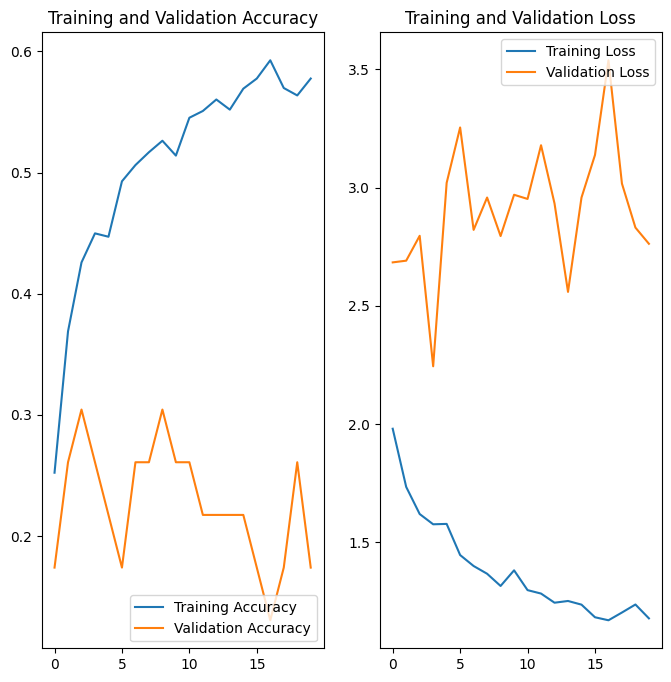

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- After data augmentation,
    - Training data accurracy: 57%
    - Validation data accuracy: 17%
- Model is still overfitting. Validation data accuracy is slightly improved when compared to previous model.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

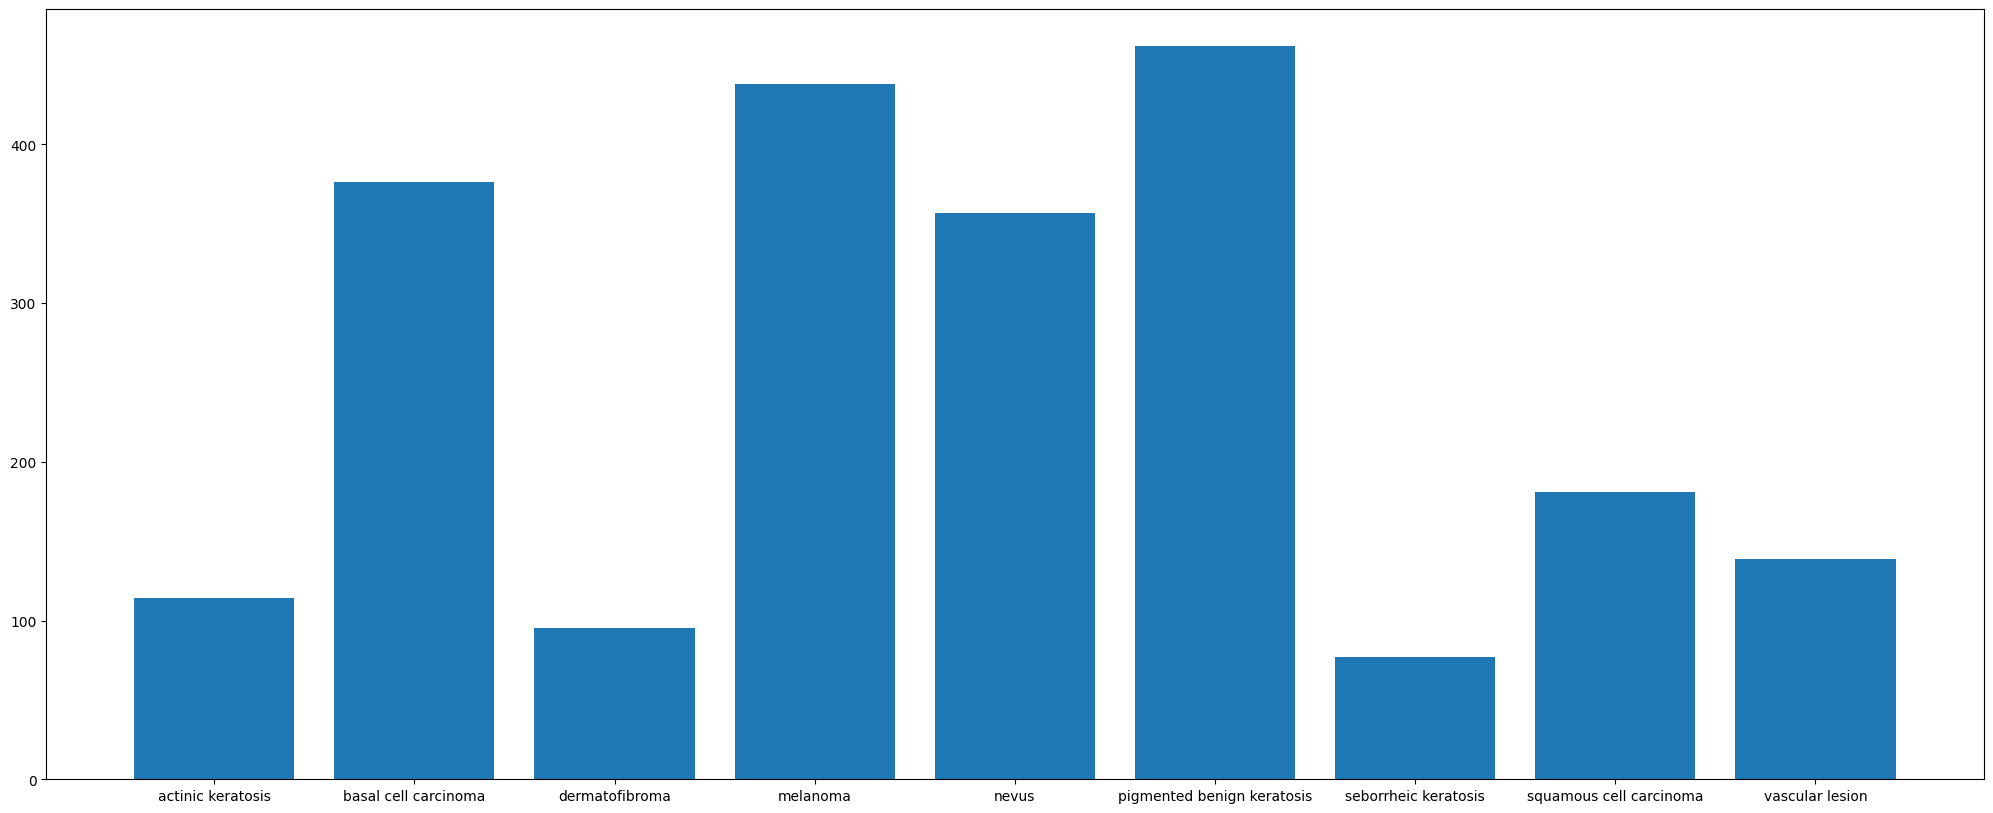

In [23]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

In [24]:
print(class_names)
print(count)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
[114, 376, 95, 438, 357, 462, 77, 181, 139]


#### Findings: 
#### - Which class has the least number of samples?
-- Seborrheic keratosis class type has the least number of samples

#### - Which classes dominate the data in terms proportionate number of samples?
-- Pigmented benign keratosis class type dominate the data in terms of number of samples followed by melanoma class type


#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train) + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Dataset/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1612FCC50>: 100%|██████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 169.33 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Dataset/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1610C8B10>: 100%|██████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 135.10 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Dataset/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x156957410>: 100%|██████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 108.60 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Dataset/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x1555B8410>: 100%|█████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.27 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x16101CA10>: 100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.94 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x15615D210>: 100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 113.82 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x155858150>: 100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 47.73 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x155975610>: 100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 98.44 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1551C2190>: 100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 102.29 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
label_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print(len(path_list))

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]
label_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print(len(path_list_new))

2239
4500


In [29]:
dataframe_dict = dict(zip(path_list, label_list))
dataframe_dict_new = dict(zip(path_list_new, label_list_new))

In [30]:
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [31]:
new_df['Label'].value_counts()

pigmented benign keratosis    924
melanoma                      876
basal cell carcinoma          752
nevus                         714
squamous cell carcinoma       362
vascular lesion               278
actinic keratosis             228
dermatofibroma                190
seborrheic keratosis          154
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [32]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [33]:
data_dir_train=pathlib.Path('./Dataset/Train')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed = 123,
  validation_split = 0.2,
  subset = 'training',
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [34]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [35]:
num_classes = 9

model_normalized = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3))
])

model_normalized.add(Conv2D(32,(3,3),activation="relu"))
model_normalized.add(BatchNormalization())
model_normalized.add(MaxPooling2D(pool_size=(3,3)))
model_normalized.add(Conv2D(64,(3,3),activation="relu"))
model_normalized.add(BatchNormalization())
model_normalized.add(MaxPooling2D(pool_size=(3,3)))
model_normalized.add(Conv2D(128,(3,3),activation="relu"))
model_normalized.add(BatchNormalization())
model_normalized.add(Conv2D(256,(3,3),activation="relu"))
model_normalized.add(BatchNormalization())
model_normalized.add(MaxPooling2D(pool_size=(3,3)))
model_normalized.add(Dropout(0.5))
model_normalized.add(Flatten())
model_normalized.add(Dense(128,activation="relu"))
model_normalized.add(Dropout(0.25))
model_normalized.add(Dense(num_classes,activation="softmax"))

model_normalized.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 178, 178, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 57, 57, 64)      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [36]:
model_normalized.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy']
              )

#### Model Training

In [37]:
epochs = 20

history = model_normalized.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/20
169/169 [==============================] - 139s 802ms/step - loss: 2.0410 - accuracy: 0.3388 - val_loss: 6.9655 - val_accuracy: 0.1195
Epoch 2/20
169/169 [==============================] - 131s 771ms/step - loss: 1.5355 - accuracy: 0.4371 - val_loss: 3.1424 - val_accuracy: 0.2442
Epoch 3/20
169/169 [==============================] - 132s 776ms/step - loss: 1.4006 - accuracy: 0.4792 - val_loss: 1.7780 - val_accuracy: 0.3927
Epoch 4/20
169/169 [==============================] - 134s 789ms/step - loss: 1.2711 - accuracy: 0.5286 - val_loss: 1.2238 - val_accuracy: 0.5590
Epoch 5/20
169/169 [==============================] - 132s 773ms/step - loss: 1.1216 - accuracy: 0.5814 - val_loss: 1.6590 - val_accuracy: 0.4840
Epoch 6/20
169/169 [==============================] - 130s 763ms/step - loss: 1.0522 - accuracy: 0.6027 - val_loss: 1.7703 - val_accuracy: 0.4736
Epoch 7/20
169/169 [==============================] - 127s 746ms/step - loss: 0.9780 - accuracy: 0.6397 - val_loss: 1.3110 -

#### Visualize the model results

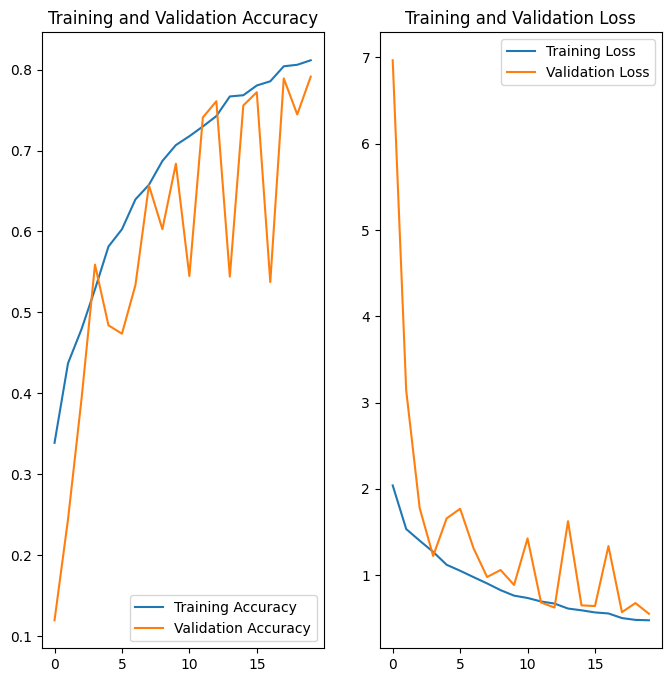

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation:
- After rectifying class imbalance in the datset, model improved significantly with training accuracy of 81% and validation accuracy of 79%
